In [15]:
import pandas as pd
from datetime import datetime, timezone
import numpy as np
import os

In [16]:
# Load all CSV files
df_fact_player = pd.read_csv('../data/Fact_Player.csv')
df_gameweeks = pd.read_csv('../data/Gameweeks.csv')
df_player_history = pd.read_csv('../data/Player_history.csv')
df_players = pd.read_csv('../data/Players.csv')
df_positions = pd.read_csv('../data/Positions.csv')
df_teams = pd.read_csv('../data/Teams.csv')
df_fixtures=pd.read_csv('../data/Fixtures.csv')


In [17]:
# Merge DataFrames with correct column names based on your schema
df_merged = (
    df_fact_player
    .merge(df_players, left_on='element', right_on='id', suffixes=('', '_player'))
    .merge(df_positions, left_on='element_type', right_on='id', suffixes=('', '_position'))
    .merge(df_teams, left_on='team', right_on='id', suffixes=('', '_team'))
    .merge(df_gameweeks, left_on='GW', right_on='id', suffixes=('', '_gameweek'))
)

# Preview the merged DataFrame
print(df_merged.head())


   element  fixture  opponent_team  total_points  was_home  \
0        1        2             20             0      True   
1        1       11              2             0     False   
2        1       21              5             0      True   
3        1       39             18             0     False   
4        1       47             13             0     False   

                kickoff_time  team_h_score  team_a_score  GW  minutes_played  \
0  2024-08-17 14:00:00+00:00             2             0   1               0   
1  2024-08-24 16:30:00+00:00             0             2   2               0   
2  2024-08-31 11:30:00+00:00             1             1   3               0   
3  2024-09-15 13:00:00+00:00             0             1   4               0   
4  2024-09-22 15:30:00+00:00             2             2   5               0   

   ...  id_gameweek     gw_name              deadline_time  highest_score  \
0  ...            1  Gameweek 1  2024-08-16 17:30:00+00:00          1

In [18]:
def save_to_csv(df, file_name):
    # Ensure the 'data' directory exists
    os.makedirs('data', exist_ok=True)
    
    # Save the CSV in the 'data' folder
    file_path = os.path.join('data', file_name)
    df.to_csv(file_path, index=False)
    print(f"Data saved to CSV file: {file_path}")

In [19]:
save_to_csv(df_merged, 'merge.csv')

Data saved to CSV file: data\merge.csv


<module 'matplotlib.pyplot' from 'C:\\Users\\KunSha\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\matplotlib\\pyplot.py'>

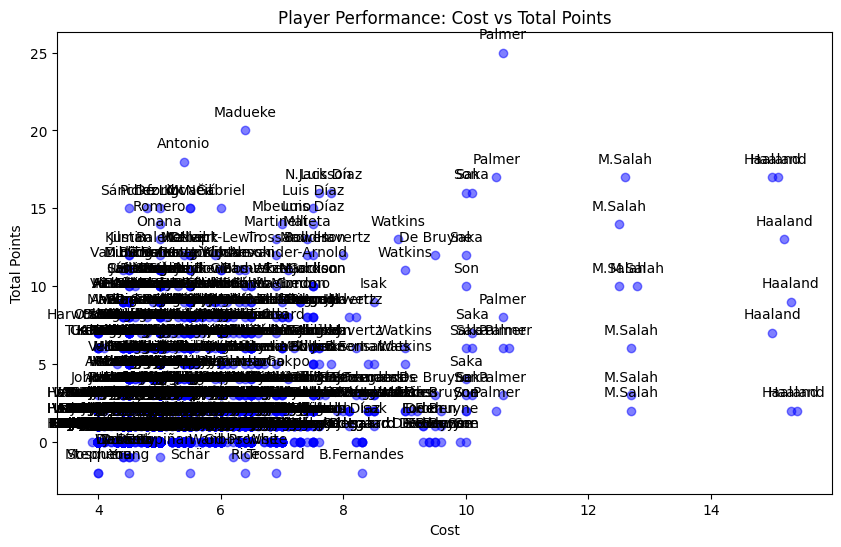

In [26]:
import matplotlib.pyplot as plt


#st.title("Player Performance Scatter Plot")

# Scatter plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['price'], df_merged['total_points'], color='blue', alpha=0.5)

# Adding labels and title
plt.title('Player Performance: Cost vs Total Points')
plt.xlabel('Cost')
plt.ylabel('Total Points')

# Annotate players
for i, player in enumerate(df_merged['web_name']):
    plt.annotate(player, (df_merged['price'][i], df_merged['total_points'][i]), textcoords="offset points", xytext=(0,10), ha='center')

# Display plot in Streamlit
plt
#st.pyplot(plt)